# Pokemon GO Visualizations based on London spawn data

Let's have first look at the data dump from the crawler that was populating a database. 

Generation
-----------

Using [PokéVision.com](https://pokevision.com/) I was able to query pokemon spawns by lat/long values. 
For this notebook I'm restricting the data to what I collected from London UK, sampling from a grid by a constant stride every 5 minutes.

I ignored the four most common pokemon up-front while crawling which were: 

```
16, // pidgey
19, // rattata
21, // spearow
41, // zubat
96 // drowzee
```

Format
------

The data format is really simple, the API returns a unique identifier and an expiration time, which tells when a pokemon despawns- this will act as our "key" to deduplicate and clean data first. 
The real juicy content is in the unique identifier of the pokemon ("pokemon_id") and its lat/long location value. 

In [76]:
import pandas as pd
df = pd.read_csv('data/data.csv', encoding="utf-8-sig")
df.head()

,id,expiration_time,pokemon_id,lat,long
0,1437290,1469531977,86,51.585117,0.079396
1,3258228,1469531978,86,51.585117,0.079396
2,3258226,1469532675,18,51.585281,0.079672
3,2403432,1469532300,7,51.576583,-0.396503
4,2387733,1469532339,13,51.575416,-0.350026


In [77]:
original_count = df['id'].count()
print('%d rows' % original_count)

68865 rows


## Cleaning the data

First off we are going to deduplicate the data, since the crawler might return some duplicated rows on failure conditions. The ID and expiration time come in very handy here and can be used as a safe unique identifier.

Afterwards we are turning the expiration time into a python datetime and add the pokemons' real name.

In [78]:
df = df.drop_duplicates(['id', 'expiration_time'])

# let's see how much we have removed
count = df['id'].count()
print('removed %d rows' % (original_count - count))
print('remaining %d rows' % count)

from datetime import datetime as dt
df['expiration_time'] = df['expiration_time'].apply(lambda x: dt.utcfromtimestamp(x))

removed 9474 rows
remaining 59391 rows


In [79]:
# join with the list of pokemons
pkmn = pd.read_csv('data/pokemon.csv', encoding="utf-8")
df = pd.merge(df, pkmn, on='pokemon_id', how='inner')
df.head()

,id,expiration_time,pokemon_id,lat,long,Name
0,1437290,2016-07-26 11:19:37,86,51.585117,0.079396,Seel
1,3258228,2016-07-26 11:19:38,86,51.585117,0.079396,Seel
2,1666641,2016-07-26 11:21:21,86,51.562280,-0.051938,Seel
3,1572259,2016-07-26 11:21:22,86,51.562280,-0.051938,Seel
4,2957601,2016-07-26 11:20:49,86,51.536197,-0.103055,Seel


## Top 10 most common Pokemon in London

In [80]:
hist = df.groupby('Name')['id'].count().sort_values(ascending=False)
hist[0:10]

Name
Magikarp    4777
Weedle      3456
Krabby      3401
Gastly      3284
Goldeen     3174
Jynx        2740
Psyduck     2452
Poliwag     2414
Staryu      2357
Caterpie    2161
Name: id, dtype: int64

Surprising find: London has tons of water type pokemon, 6 out of the 10! 
We will later on figure out if the rumoured affinitization of water and water type pokemon holds.

## Plotting Charmander location

In [81]:
import geoplotlib as g
from geoplotlib.utils import BoundingBox, DataAccessObject

def savePlotOnLondonMap(data, fileName):
    # define london
    LDN = BoundingBox(north=51.547, west=-0.239, south=51.451011, east=0.072161)
    # massage the data into a format that geoplotlib understands
    geodf = data[['lat', 'long']].copy()
    geodf.rename(columns={'lat': 'lat', 'long': 'lon'}, inplace=True)
    
    g.tiles_provider('positron')
    g.kde(DataAccessObject.from_dataframe(geodf), bw=1)
    g.set_bbox(LDN)
    g.savefig(fileName)
    # inline unfortunately doesn't work :/
    # g.inline()

# plot everything
savePlotOnLondonMap(df, 'img/alllocations')

# give me all charmander locations
geodf = df[df['pokemon_id'] == 4] 
savePlotOnLondonMap(geodf, 'img/charmanderlocations')

('smallest non-zero count', 0.037444165055830925)
('max count:', 17.260633983249743)
('smallest non-zero count', 1.7910636084771928e-08)
('max count:', 1.7905003081465174)


Let's look at the output:

![title](img/alllocations.png)

Very busy map, you find that the most pokemons are sighted where a lot of people seem to be, especially parks and touristy areas like Westminster/Greenich/Hyde Park. Keep in mind that there is a selection bias, the PokeVision API caches the results heavily and only refreshes on a user request. So parts of London where nobody is using their service, we won't have any data.

Let's look at the Charmander spawns:

![title](img/charmanderlocations.png)

There seems to be a so called "nest" in Holland Park and in the Stratford Olympic Park, where there seem to be an unusually high density of Charmanders.

## Automatically finding nests of pokemon

To find nests, we are going to use a simple density based clustering algorithm called DBSCAN for every pokemon where we have more than twenty data points available. Then we simply print out the mean of the point in one cluster and plot it on the map.

In [82]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics

for x in df['pokemon_id'].sort_values().unique():   
    dff = df[df['pokemon_id'] == x]   
    cnt = dff['id'].count()
    if cnt > 20:
       dff = dff[['lat', 'long']].copy()
       db = DBSCAN(eps=0.001, min_samples=10, metric='haversine', algorithm='ball_tree').fit(dff.as_matrix())
       pkname = pkmn[pkmn['pokemon_id'] == x].iloc[0]['Name']
       labels = db.labels_
       core_samples_mask = np.zeros_like(labels, dtype=bool)
       core_samples_mask[db.core_sample_indices_] = True
       unique_labels = set(labels)
        
       n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
       if(n_clusters > 1):
           print('found clusters for %s, number of pokemon %d' % (pkname, cnt))
           print('number of clusters: %d' % n_clusters)
           tp = pd.DataFrame(columns=['lat','long'])
           for k in unique_labels:
              # ignore class noise when printing            
              if k != -1:           
                 class_member_mask = (labels == k)
                 output = dff[class_member_mask & core_samples_mask]
                 tp = tp.append(output)
                 center = output.mean()
                 kcount = output['lat'].count()
                 print('found cluster \'%d\' at %f/%f with %d occurrences' % (k, center['lat'], center['long'], kcount))    
           # plot all the clusters in a single map
           savePlotOnLondonMap(tp, 'img/{}_nests'.format(pkname))
           print()
    

found clusters for Bulbasaur, number of pokemon 212
number of clusters: 6
found cluster '0' at 51.547405/-0.148804 with 19 occurrences
found cluster '1' at 51.523429/-0.019613 with 19 occurrences
found cluster '2' at 51.510901/-0.308507 with 14 occurrences
found cluster '3' at 51.516152/-0.068608 with 25 occurrences
found cluster '4' at 51.557713/-0.214034 with 12 occurrences
found cluster '5' at 51.500870/-0.083849 with 14 occurrences
('smallest non-zero count', 7.1642544339087712e-08)
('max count:', 1.4507290680620923)

found clusters for Charmander, number of pokemon 397
number of clusters: 6
found cluster '0' at 51.502870/-0.203780 with 159 occurrences
found cluster '1' at 51.495609/-0.256219 with 22 occurrences
found cluster '2' at 51.510709/-0.212334 with 18 occurrences
found cluster '3' at 51.539986/-0.010467 with 31 occurrences
found cluster '4' at 51.542764/-0.017735 with 5 occurrences
found cluster '5' at 51.580638/0.012742 with 5 occurrences
('smallest non-zero count', 3.582

## Interesting nest locations 

#### Magikarp

Very closely found to locations with Water nearby
![title](img/Magikarp_nests.png)


#### Vulpix

Found very near to Barbican.
![title](img/Vulpix_nests.png)


#### Voltorb

Nests at Canning Town and Stratford.
![title](img/Voltorb_nests.png)

#### Pikachu

One big nest at the park near Old Street.

![title](img/Pikachu_nests.png)

#### Electabuzz

![title](img/Electabuzz_nests.png)

Go and checkout the other cluster outputs in the img folder!

## Analysing spawn timings

Let's pick Vulpix, since I need some and see if we find any pattern in the times they spawn. Note that we only have the expiration time, but we know since Vulpix are relatively common, the despawn timer should be 15 minutes. 

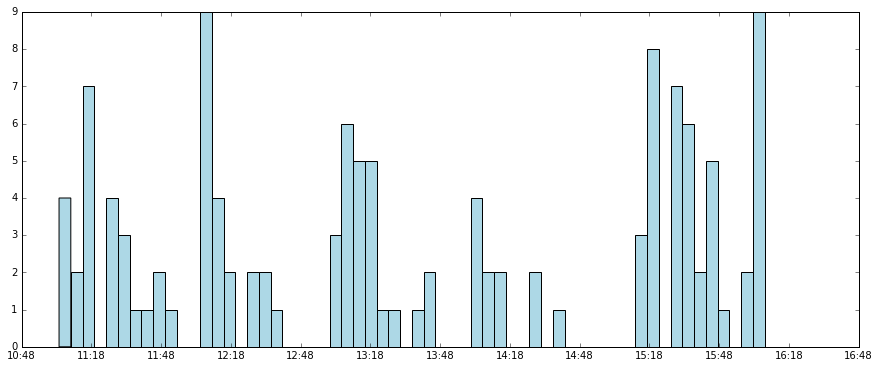

In [84]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

delta = datetime.timedelta(minutes=15)
vpx = df[df['pokemon_id'] == 37]['expiration_time'].apply(lambda x: x - delta).tolist()

# get the number of bins, by taking the number of 5 minute buckets we have in the data
bins = int((max(vpx)-min(vpx)).total_seconds() / (5 * 60))

mpl_data = mdates.date2num(vpx)

figsize(15, 6)
fig, ax = plt.subplots(1,1)
ax.hist(mpl_data, bins=bins, color='lightblue')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.show()

We might see some minor correlation with beginning of the hour, but otherwise it is hard to tell what's going on without gathering more data over the next days. 